## **Network Intrusion Detection System** 

 Detect the type of activity by predicting whether it is Normal, Back, Buffer Overflow, FTP Write, Guess Password, Neptune, N-Map, Port Sweep, Root Kit, Satan, or Smurf.


#### **Import Libraries** 

In [34]:
# import packages
import os
import sys 
import math
import pickle
import joblib
import pandas as pd 
pd.options.display.max_columns = None
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot')

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import  RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import  RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import  confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#### **Load the data**

In [2]:
network_intrusion_df = pd.read_csv('multiclass_network_attack.csv')
network_intrusion_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_error_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0.0,0.0,0.0,0.0,0.00215,0.45076,0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.001,0.001,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,Normal
1,0.0,0.0,0.0,0.0,0.00162,0.04528,0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.002,0.002,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.001,0.001,0.1,0.0,0.100,0.0,0.0,0.0,0.0,0.0,Normal
2,0.0,0.0,0.0,0.0,0.00236,0.01228,0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.001,0.001,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.002,0.002,0.1,0.0,0.050,0.0,0.0,0.0,0.0,0.0,Normal
3,0.0,0.0,0.0,0.0,0.00233,0.02032,0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.002,0.002,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.003,0.003,0.1,0.0,0.033,0.0,0.0,0.0,0.0,0.0,Normal
4,0.0,0.0,0.0,0.0,0.00239,0.00486,0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.003,0.003,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.004,0.004,0.1,0.0,0.025,0.0,0.0,0.0,0.0,0.0,Normal


### **Feature Engineering** 

In [3]:
# Target class distribution
network_intrusion_df['attack_type'].value_counts()

attack_type
Normal            576710
Neptune           227228
Satan               5019
Smurf               3007
PortSweep           2964
NMap                1554
Back                 968
GuessPassword         53
BufferOverflow        30
RootKit               10
FTPWrite               8
Name: count, dtype: int64

In [4]:
# clear white-space
network_intrusion_df.columns = network_intrusion_df.columns.str.strip()

In [5]:
# drop duplicates 
network_intrusion_df.drop_duplicates(inplace=True)

In [6]:
# drop missing values
network_intrusion_df.dropna(inplace=True)

In [7]:
# drop columns with zero standard deviation 
def cols_with_zero_std(df: pd.DataFrame):
    
    cols_to_drop = []
    # Select numerical columns only
    num_columns = [col for col in df.columns if df[col].dtype != 'O']

    for col in num_columns:
        if df[col].std() == 0:
            cols_to_drop.append(col)
    return cols_to_drop

# features with zero standard deviation 
cols_to_drop_1 = cols_with_zero_std(df=network_intrusion_df) 
print(cols_to_drop_1)

['land', 'num_outbound_cmds']


In [8]:
# drop features with zero std because they dont contribute to model training. 
network_intrusion_df.drop(cols_to_drop_1, axis=1, inplace=True)

In [9]:
# list of all features 
features = network_intrusion_df.drop('attack_type', axis=1).columns.tolist()

# Nominal Features
nominal_features = ['protocol_type', 'service', 'flag']

# Binary Features
binary_features = ['logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

#####  Explore and  Engineer Nominal Features 

In [10]:
for col in nominal_features:
    print(f"Frequency of  {col}:")
    print(network_intrusion_df[col].value_counts())
    print('==='*30)

Frequency of  protocol_type:
protocol_type
0.00    776566
0.01     35402
0.02      5583
Name: count, dtype: int64
Frequency of  service:
service
0.00    462331
0.12    181678
0.01     53979
0.02     31806
0.14     21976
         ...  
0.38         5
0.64         2
0.65         2
0.67         2
0.63         1
Name: count, Length: 67, dtype: int64
Frequency of  flag:
flag
0.00    570819
0.07    202685
0.05     38579
0.06      2541
0.08      2020
0.02       331
0.10       298
0.09       122
0.01        97
0.04        40
0.03        19
Name: count, dtype: int64


In [11]:
# reduce dimenstion by combining minority nominal classes. 
service_thresold = 20000

#count frequency of each category. 
service_category_count = network_intrusion_df['service'].value_counts()

# identify minority category below threshold
minority_cat =  service_category_count[service_category_count < service_thresold].index

# replace minority category with others 
network_intrusion_df['service'] = network_intrusion_df['service'].apply(lambda x: 'others' if x in minority_cat else x)


In [12]:
# reduce dimenstion by combining minority nominal classes. 
service_thresold = 35000

#count frequency of each category. 
flag_category_count = network_intrusion_df['flag'].value_counts()

# identify minority category below threshold
minority_cat =  flag_category_count[flag_category_count < service_thresold].index

# replace minority category with others 
network_intrusion_df['flag'] = network_intrusion_df['flag'].apply(lambda x: 'others' if x in minority_cat else x)

##### Explore and Engineer Binary features 

In [13]:
for col in binary_features:
    print(f"Frequency of  {col}:")
    print(network_intrusion_df[col].value_counts())
    print('==='*30)

Frequency of  logged_in:
logged_in
0.1    521695
0.0    295856
Name: count, dtype: int64
Frequency of  root_shell:
root_shell
0.0    817300
0.1       251
Name: count, dtype: int64
Frequency of  su_attempted:
su_attempted
0.0    817496
0.2        36
0.1        19
Name: count, dtype: int64
Frequency of  is_host_login:
is_host_login
0.0    817550
0.1         1
Name: count, dtype: int64
Frequency of  is_guest_login:
is_guest_login
0.0    815286
0.1      2265
Name: count, dtype: int64


In [14]:
# drop highly imbalanced  binary features they don't contribute to model 
network_intrusion_df.drop(['root_shell', 'su_attempted', 'is_host_login'], axis=1, inplace=True)

In [15]:
# update binary features list
binary_features = [x for x in binary_features if x not in ['root_shell', 'su_attempted', 'is_host_login']]
print(binary_features)

['logged_in', 'is_guest_login']


#### Target encoding

In [16]:
# Initialize LabelEncoder
encoder = LabelEncoder()
# Encode the 'attack_type' column and create a new column 'attack_enc' with encoded labels
network_intrusion_df['attack_enc']  = encoder.fit_transform(network_intrusion_df['attack_type'])
# Print mapping of original class labels to their corresponding encoded integer labels
print("Mapping of classes to integers:")
for class_label, encoded_label in zip(encoder.classes_, encoder.transform(encoder.classes_)):
    print(f"{class_label} : {encoded_label}")

Mapping of classes to integers:
Back : 0
BufferOverflow : 1
FTPWrite : 2
GuessPassword : 3
NMap : 4
Neptune : 5
Normal : 6
PortSweep : 7
RootKit : 8
Satan : 9
Smurf : 10


In [17]:
#drop raw target column
network_intrusion_df.drop('attack_type', axis=1, inplace=True)


In [18]:
# one-hot encoding of nominal categorical features 
network_intrusion_df= pd.get_dummies(network_intrusion_df, columns=nominal_features, drop_first=True)

In [19]:
# seperate features and target
X = network_intrusion_df.drop('attack_enc', axis=1)
y = network_intrusion_df['attack_enc']

Remove highly correlated features 

In [20]:
# function to listt all highly correalted features 
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [21]:
# remove highly correlated features
corr_features = correlation(X, 0.9)
print("Highly correlated features :",corr_features)
X.drop(corr_features, axis=1, inplace=True)

Highly correlated features : {'dst_host_serror_rate', 'srv_rerror_rate', 'srv_error_rate', 'dst_host_same_srv_rate', 'dst_host_srv_serror_rate', 'service_0.02', 'flag_0.07', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'is_guest_login', 'flag_0.05'}


### Handle class imbalance 

In [22]:
# target class distribution 
network_intrusion_df['attack_enc'].value_counts()

attack_enc
6     576710
5     227228
9       5019
10      3007
7       2964
4       1554
0        968
3         53
1         30
8         10
2          8
Name: count, dtype: int64

#### **Resampling**

Split the resampled data into training and testing sets with a 70-30 split. Use a fixed random seed (42) for reproducibility and employ stratified sampling to preserve the class distribution in both sets. Stratified sampling is crucial for maintaining a representative balance of classes, especially in the context of imbalanced datasets.

In [23]:
# Check the class distribution before resampling
print("Class distribution before resampling: \n", Counter(y))
# Oversample the minority classes using SMOTE with Tomeklinks
smote = SMOTETomek(sampling_strategy={4: 2000,  0: 1500, 3: 1000, 1: 800, 8: 600, 2: 500}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Check the class distribution after resampling
print("Class distribution after resampling: \n", Counter(y_resampled))

Class distribution before resampling: 
 Counter({6: 576710, 5: 227228, 9: 5019, 10: 3007, 7: 2964, 4: 1554, 0: 968, 3: 53, 1: 30, 8: 10, 2: 8})
Class distribution after resampling: 
 Counter({6: 576692, 5: 227227, 9: 4999, 10: 3007, 7: 2960, 4: 1996, 0: 1500, 3: 1000, 1: 800, 8: 599, 2: 500})


#### **Train test split**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

In [25]:
# shape of train and test feature set
X_train.shape , X_test.shape

((574896, 32), (246384, 32))

#### **Feature scaling**



Numerical features are scaled using the RobustScaler. The process involves isolating only the numerical features from the original datasets (`X_train` and `X_test`). The RobustScaler is then applied to standardize these numerical features, and the scaled features are integrated back into the corresponding datasets. This ensures that only the numerical features are scaled, leaving categorical features unchanged. RobustScaler is chosen for its ability to handle outliers robustly.


In [26]:
# list encoded nominal features 
import re
service_columns = [col for col in X_train.columns if re.search('service', col)]
flag_columns = [col for col in X_train.columns if re.search('flag', col)]
protocol_columns = [col for col in X_train.columns if re.search('protocol', col)]

nominal_columns = service_columns + flag_columns + protocol_columns
print(nominal_columns)


['service_0.01', 'service_0.12', 'service_0.14', 'service_others', 'flag_others', 'protocol_type_0.01', 'protocol_type_0.02']


In [27]:
# extract all the feature names
all_features = X_train.columns
# Create a list of numeric features by excluding nominal and binary features
numeric_features = [feature for feature in all_features if feature not in (binary_features + nominal_columns)]
# Display the list of numeric features
print("Numeric Features:", numeric_features)


Numeric Features: ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate']


In [31]:
# scale numerical features 
scaler = RobustScaler()

# isolate only numerical features to scale
X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]

# scale numerical features 
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# create a copy of train and test features
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# only numerical features are scaled in the train and test feature set
X_train_scaled[numeric_features] = X_train_num_scaled
X_test_scaled[numeric_features] = X_test_num_scaled

___________________________

#### **Model Selection**

In this section, multiple classification models, including Decision Tree, Random Forest, ExtraTreeClassifier, XGBoost, and CatBoostClassifier, are trained and evaluated on a dataset with scaled features. For each model, evaluation metrics such as accuracy, precision, recall, and F1 score are calculated and printed. Additionally, the feature importances for models that support this attribute (Decision Tree, Random Forest, ExtraTreeClassifier) are captured and stored in a DataFrame. The confusion matrix for each model is displayed, providing insights into classification performance. Finally, the feature importance DataFrame is saved to a CSV file named 'feature_importance.csv'.

Model: Decision Tree
Accuracy: 0.9998
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9998


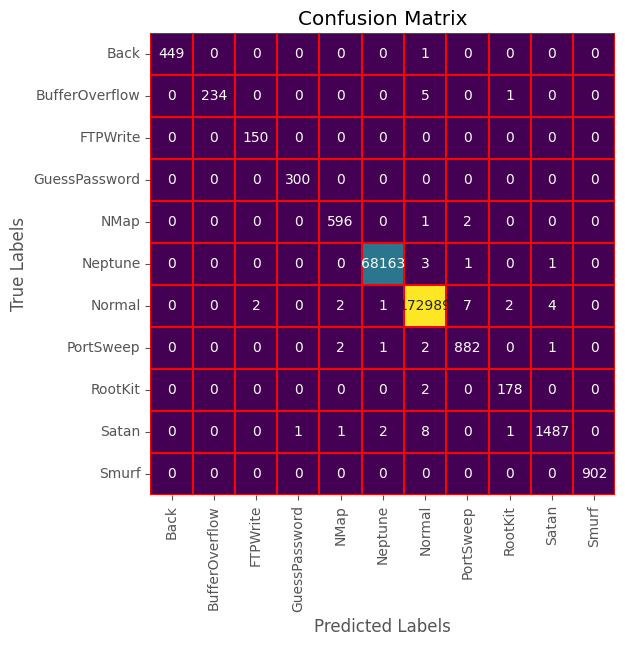

Model: Random Forest
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999


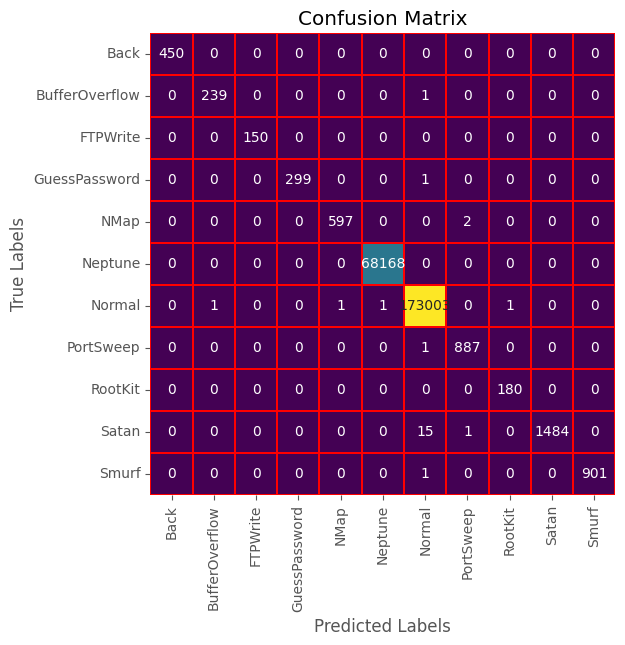

Model: ExtraTreeClassifier
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F1 Score: 0.9996


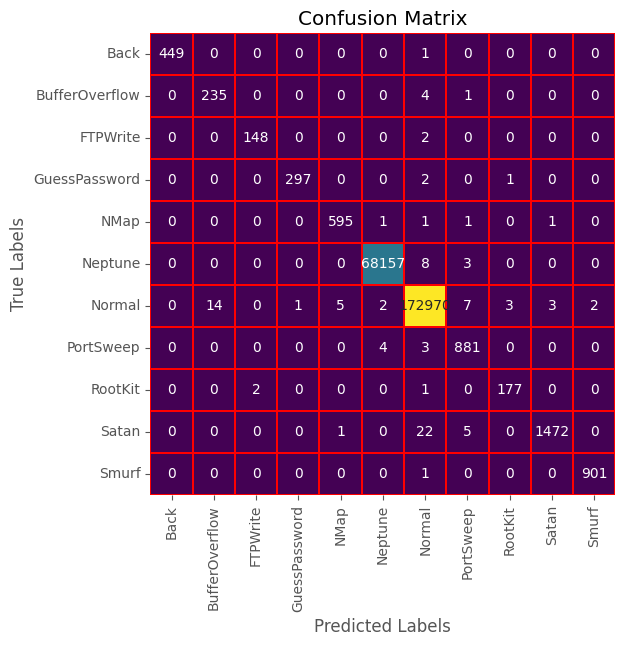

Model: XGBoost
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999


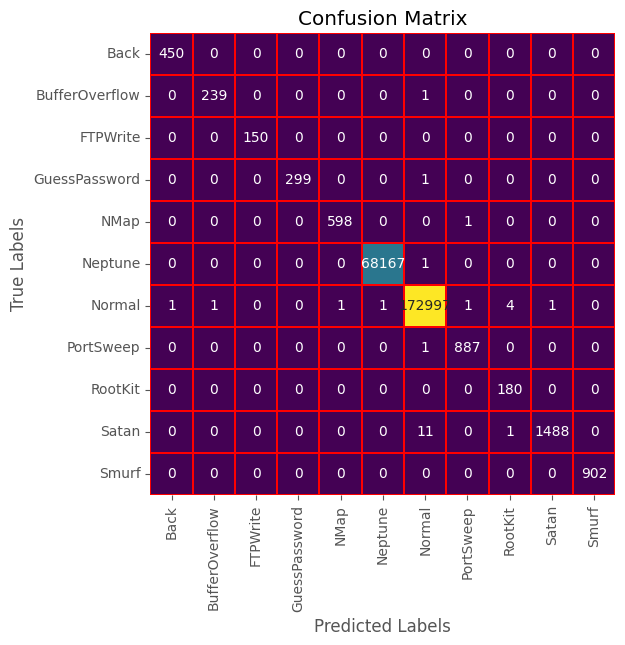

Model: CatBoostClassifier
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999


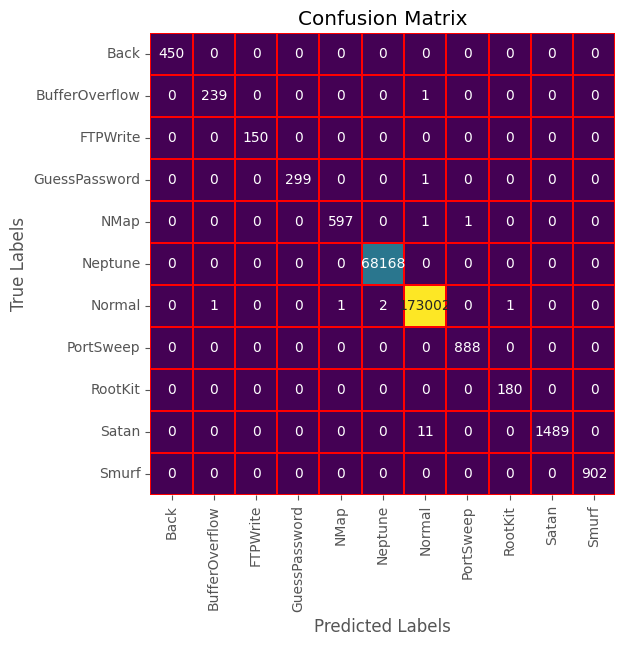

In [35]:
# Create an empty dictionary to store feature importances
feature_importance_dict = {}

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "ExtraTreeClassifier": ExtraTreeClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=False),
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print the evaluation metrics for each model
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate and save feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importance_dict[model_name] = model.feature_importances_
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Mapping of classes to their corresponding names
    class_names = ['Back', 'BufferOverflow', 'FTPWrite', 'GuessPassword', 'NMap', 'Neptune', 'Normal', 'PortSweep', 'RootKit', 'Satan', 'Smurf']
    
    # Display the confusion matrix with centered ticks
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=0.3, linecolor='red', cmap='viridis', cbar=False)

    # Set the ticks at the center of each square
    ax.set_xticks(np.arange(len(class_names)) + 0.5, minor=False)
    ax.set_yticks(np.arange(len(class_names)) + 0.5, minor=False)

    # Set the tick labels
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names, rotation=0)

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("===" * 20)

# Convert the dictionary to a DataFrame
feature_importance_df = pd.DataFrame(feature_importance_dict, index=X_train_scaled.columns)

# Save feature importance to a CSV file
feature_importance_df.to_csv('feature_importance.csv')

After a comprehensive evaluation of multiple classification models, including Decision Tree, Random Forest, ExtraTreeClassifier, XGBoost, and CatBoostClassifier, it is observed that the error metrics, namely Accuracy Score, Precision, Recall, and F1-Score, exhibit similar performance across all models.

Upon closer examination of the confusion matrices, it is noteworthy that the CatBoostClassifier model demonstrates a reduction in misclassifications compared to other models. As minimizing misclassifications is a critical aspect of model selection, we have chosen the CatBoostClassifier for further model training and deployment.

This decision is driven by the model's ability to handle the dataset effectively, resulting in fewer instances of misclassification. The CatBoostClassifier is poised to deliver robust performance and generalization on unseen data, making it the preferred choice for our classification task.

#### **Model Training using `CatBoostClassifier`**

Model: CatBoostClassifier
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       450
           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       599
           5       1.00      1.00      1.00     68168
           6       1.00      1.00      1.00    173007
           7       1.00      1.00      1.00       888
           8       0.99      1.00      1.00       180
           9       1.00      0.99      1.00      1500
          10       1.00      1.00      1.00       902

    accuracy                           1.00    246384
   macro avg       1.00      1.00      1.00    246384
weighted avg       1.00      1.00      1.00    246384



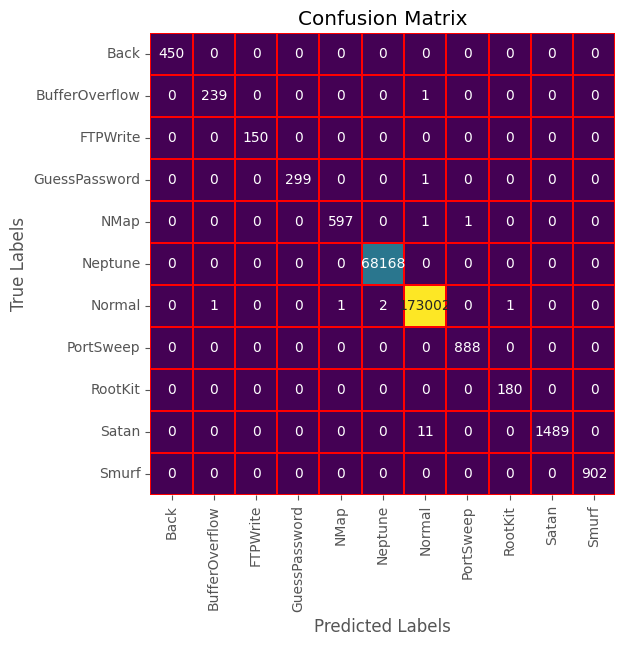

In [42]:
# Initialize the XGBoost classifier
catboost_clf = CatBoostClassifier(verbose=False)
# fit the model on the training data
catboost_clf.fit(X_train_scaled, y_train)
# Use the trained model to make predictions on the test data
y_pred = catboost_clf.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics for each model
print("Model: CatBoostClassifier")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# calcualte confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Mapping of classes to their corresponding names
class_names = ['Back', 'BufferOverflow', 'FTPWrite', 'GuessPassword', 'NMap', 'Neptune', 'Normal', 'PortSweep', 'RootKit', 'Satan', 'Smurf']
# Display the confusion matrix with centered ticks
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=0.3, linecolor='red', cmap='viridis', cbar=False)

# Set the ticks at the center of each square
ax.set_xticks(np.arange(len(class_names)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(class_names)) + 0.5, minor=False)

# Set the tick labels
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# save the model 
model_filename = 'catboost_multiple_attack_classification.pkl'
joblib.dump('catboost_clf', model_filename)

['catboost_multiple_attack_classification.pkl']